# 01 – Data Exploration

This notebook inspects the raw image inventory and the derived labeling artifacts. It expects the preprocessing step to have produced `image_manifest.csv`, `majority_labels.csv`, and `label_summary.json` under `/app/output`. The focus is to understand dataset size, folder/source composition, and the gap between available images and labels.

In [1]:
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

output_root = Path("/app/output")
manifest_path = output_root / "image_manifest.csv"
labels_path = output_root / "majority_labels.csv"
summary_path = output_root / "label_summary.json"
print(manifest_path)
print(labels_path)
# Helper to ensure directories exist for exports
def ensure_dir(path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    return path


/app/output/image_manifest.csv
/app/output/majority_labels.csv


## Load manifest and labels

In [2]:
manifest = pd.read_csv(manifest_path) if manifest_path.exists() else pd.DataFrame()
majority_labels = pd.read_csv(labels_path) if labels_path.exists() else pd.DataFrame()

dataset = pd.DataFrame()
missing = pd.DataFrame()

print(f"Manifest rows: {len(manifest)}")
print(f"Majority labels rows: {len(majority_labels)}")

summary = {}
if summary_path.exists():
    summary = json.loads(summary_path.read_text(encoding="utf-8"))
    display(summary)


Manifest rows: 379
Majority labels rows: 423


{'total_images': 379,
 'labeled_images': 324,
 'unlabeled_images': 55,
 'label_coverage_rate': 0.8548812664907651,
 'class_distribution': {'Neutral': 170, 'Pronation': 124, 'Supination': 30},
 'source_distribution': {'internet': 178, 'sajat': 201},
 'unknown_labels_present': False}

## Dataset composition

In [3]:
if manifest.empty:
    print("Manifest is empty or missing; run preprocessing first.")
else:
    display(manifest.head())
    by_folder = manifest.groupby("folder").size().sort_values(ascending=False)
    by_source = manifest.groupby("source").size()
    by_identifier = manifest.groupby("identifier").size().sort_values(ascending=False)

    print("Images by folder (top 10):")
    display(by_folder.head(10))

    print("Images by source:")
    display(by_source)

    print("Images by identifier (top 10):")
    display(by_identifier.head(10))


,file_upload,relative_path,folder,source,identifier,sequence,extension
0,internet_actualne_01.jpg,B8V41Y/internet_actualne_01.jpg,B8V41Y,internet,actualne,1,jpg
1,internet_algeos_01.jpg,B8V41Y/internet_algeos_01.jpg,B8V41Y,internet,algeos,1,jpg
2,internet_everypixel_01.jpg,B8V41Y/internet_everypixel_01.jpg,B8V41Y,internet,everypixel,1,jpg
3,internet_facebook_01.jpg,B8V41Y/internet_facebook_01.jpg,B8V41Y,internet,facebook,1,jpg
4,internet_freepic_02.jpg,B8V41Y/internet_freepic_02.jpg,B8V41Y,internet,freepic,2,jpg


Images by folder (top 10):


folder
GI9Y8B    51
GK1XQ4    51
ECSGGY    33
C6037J    33
FO6K58    25
H51B9J    23
ITWQ3V    23
D6AE9F    22
NX9GA4    20
XV0M8Z    20
dtype: int64

Images by source:


source
internet    178
sajat       201
dtype: int64

Images by identifier (top 10):


identifier
resztvevo01    17
reszvevo01     16
google         16
resztvevo02    15
reszvevo02     15
resztvevo03    14
resztvevo04    13
reszvevo03     12
reszvevo04     11
freepik         9
dtype: int64

## Visualization: source and identifier distribution

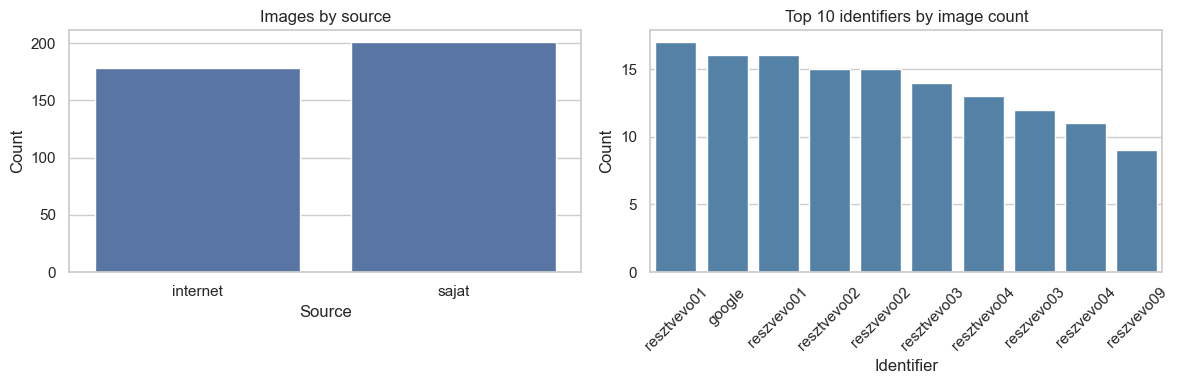

In [8]:
if not manifest.empty:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(x="source", data=manifest, ax=axes[0])
    axes[0].set_title("Images by source")
    axes[0].set_xlabel("Source")
    axes[0].set_ylabel("Count")

    top_ids = manifest["identifier"].value_counts().nlargest(10).reset_index()
    top_ids.columns = ["identifier", "count"]
    sns.barplot(x="identifier", y="count", data=top_ids, ax=axes[1], color="steelblue")
    axes[1].set_title("Top 10 identifiers by image count")
    axes[1].set_xlabel("Identifier")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    ensure_dir(output_root / "figures" / "source_identifier.png")
    plt.savefig(output_root / "figures" / "source_identifier.png", dpi=150)
    plt.show()


## Label coverage

Labeled images: 324 / 379 (85.5%)
Unlabeled images: 55
Labeled images by source:


source
internet    128
sajat       196
Name: file_upload, dtype: int64

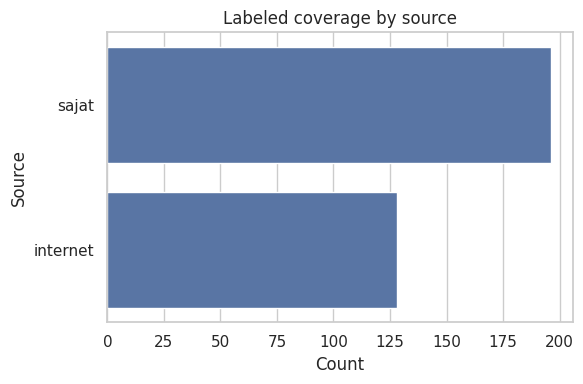

In [4]:
if manifest.empty or majority_labels.empty:
    print("Manifest or labels missing; run preprocessing first.")
else:
    dataset = manifest.merge(majority_labels, on="file_upload", how="left")
    labeled = dataset[dataset["majority_label"].notna()]
    missing = dataset[dataset["majority_label"].isna()]

    print(f"Labeled images: {len(labeled)} / {len(dataset)} ({len(labeled)/len(dataset):.1%})")
    print(f"Unlabeled images: {len(missing)}")

    by_source = labeled.groupby("source")["file_upload"].count()
    print("Labeled images by source:")
    display(by_source)

    plt.figure(figsize=(6, 4))
    sns.countplot(y="source", data=labeled, order=by_source.sort_values(ascending=False).index)
    plt.title("Labeled coverage by source")
    plt.xlabel("Count")
    plt.ylabel("Source")
    ensure_dir(output_root / "figures" / "label_coverage_by_source.png")
    plt.tight_layout()
    plt.savefig(output_root / "figures" / "label_coverage_by_source.png", dpi=150)
    plt.show()


## Missing labels (top examples)

In [5]:
if not dataset.empty:
    top_missing = missing.head(10)
    print("Sample of unlabeled images (top 10):")
    display(top_missing)


Sample of unlabeled images (top 10):


,file_upload,relative_path,folder,source,identifier,sequence,extension,majority_label,annotations_count,majority_votes
153,internet_2ftorthotics_01.png,GI9Y8B/internet_2ftorthotics_01.png,GI9Y8B,internet,2ftorthotics,1,png,NaN,NaN,NaN
154,internet_2ftorthotics_02.png,GI9Y8B/internet_2ftorthotics_02.png,GI9Y8B,internet,2ftorthotics,2,png,NaN,NaN,NaN
155,internet_acangasolucoes_01.png,GI9Y8B/internet_acangasolucoes_01.png,GI9Y8B,internet,acangasolucoes,1,png,NaN,NaN,NaN
156,internet_adelaideankle_01.png,GI9Y8B/internet_adelaideankle_01.png,GI9Y8B,internet,adelaideankle,1,png,NaN,NaN,NaN
157,internet_amboss_01.jpg,GI9Y8B/internet_amboss_01.jpg,GI9Y8B,internet,amboss,1,jpg,NaN,NaN,NaN
158,internet_atoskliniken_01.png,GI9Y8B/internet_atoskliniken_01.png,GI9Y8B,internet,atoskliniken,1,png,NaN,NaN,NaN
159,internet_atoskliniken_02.png,GI9Y8B/internet_atoskliniken_02.png,GI9Y8B,internet,atoskliniken,2,png,NaN,NaN,NaN
160,internet_audioglobal_01.png,GI9Y8B/internet_audioglobal_01.png,GI9Y8B,internet,audioglobal,1,png,NaN,NaN,NaN
161,internet_bofas_01.jpg,GI9Y8B/internet_bofas_01.jpg,GI9Y8B,internet,bofas,1,jpg,NaN,NaN,NaN
162,internet_bofas_02.jpg,GI9Y8B/internet_bofas_02.jpg,GI9Y8B,internet,bofas,2,jpg,NaN,NaN,NaN
